In [22]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    AdaBoostClassifier,
    BaggingClassifier
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score,roc_auc_score,matthews_corrcoef
)
import warnings
warnings.filterwarnings('ignore')
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os
os.environ['KAGGLE_USERNAME'] = "sampathmallagundla"
os.environ['KAGGLE_KEY'] = "8ca6bbfec3f8bfdc6c0442a31a2e0d98"
from kaggle.api.kaggle_api_extended import KaggleApi
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [23]:

# =============================================================================
# SECTION 1: DATA LOADING AND PREPARATION
# =============================================================================

def load_loan_data(filepath=None):

    if filepath:
        print(f"Loading data from: {filepath}")
        df = pd.read_csv(filepath)
    else:
        dataset_slug = 'architsharma01/loan-approval-prediction-dataset'
        download_path = 'D:\\MyWorkSpace\\ML Assignments\\data\\loan-approval-prediction-dataset'
        
        api = KaggleApi()
        api.authenticate()
        # Check if dataset already exists
        if not os.path.exists(download_path) or not os.listdir(download_path):
            print("Dataset not found locally. Downloading from Kaggle...")
            api.dataset_download_files(dataset_slug, path=download_path, unzip=True)
            print("Download complete.")
        else:
            print("Dataset already exists locally. Skipping download.")

        
        try:
            print(f"Attempting to download from: {'loan_approval_dataset.csv'}")
            df = pd.read_csv('D:\\MyWorkSpace\\ML Assignments\\data\\loan-approval-prediction-dataset\\loan_approval_dataset.csv')
            print("Successfully downloaded dataset!")
        except Exception as e:
            print(f"Could not download dataset: {e}")
            print("\nPlease download the dataset manually from:")
            print("https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset")
            return None

    return df

In [24]:
def explore_data(df):
    """
    Perform exploratory data analysis on the dataset.
    """
    print("\n" + "="*60)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*60)

    print(f"\nDataset Shape: {df.shape}")
    print(f"Total Customers: {len(df):,}")

    print("\nColumn Names:")
    print(df.columns.tolist())

    print("\nData Types:")
    print(df.dtypes)

    print("\nMissing Values:")
    print(df.isnull().sum()[df.isnull().sum() > 0])

    print("\nLoan Status Distribution:")
    print(df[' loan_status'].value_counts())
    print(f"\nApproved Rate: {df[' loan_status'].value_counts(normalize=True).get('Approved', df[' loan_status'].value_counts(normalize=True).get(1, 0)):.2%}")

    return df

In [25]:
from torch import le


def preprocess_loan_data(df):
    """
    Preprocess the dataset by handling missing values, encoding categorical variables, and scaling features.
    """
    print("\n" + "="*60)
    print("DATA PREPROCESSING")
    print("="*60)

    

    #Strip leading/trailing spaces from column names
    df.columns = df.columns.str.strip()

    #strip leading/trailing spaces from string columns
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].str.strip()


    # Handle missing values
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)

    # Encode target variable
    #df['loan_status'] = df['loan_status'].map({'Approved': 1, 'Rejected': 0})

    # Separate features and target
    X = df.drop('loan_status', axis=1)
    y = df['loan_status']

    # Identify numeric and categorical columns
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object']).columns

    # Create transformers for numeric and categorical features
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    return X, y, preprocessor

In [26]:
def prepare_data_splits(X, y,test_size=0.2, random_state=42):
    """
    Split data into training and testing sets.
    """
    #df processed is with features after encoding and scaling and droping target variable
    #X = df_processed.drop('loan_status', axis=1)
    #y = df_processed['loan_status']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Scale features
    #scaler = StandardScaler()
    #X_train_scaled = scaler.fit_transform(X_train)
    #X_test_scaled = scaler.transform(X_test)

    print(f"\nTraining set: {len(X_train):,} samples")
    print(f"Test set: {len(X_test):,} samples")
    print(f"Features: {X_train.shape[1]}")
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

 
    #return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler
    return X_train, X_test, y_train_encoded, y_test_encoded, le

# =============================================================================
# SECTION 2: MODEL IMPLEMENTATIONS
# =============================================================================

In [27]:

def train_logistic_regression(X_train, y_train_encoded,preprocessor,le):
    """
    Train and evaluate Logistic Regression model.
    """
    print("\n" + "="*60)
    print("LOGISTIC REGRESSION")
    print("="*60)

    # Model with regularization tuning
    #lr = LogisticRegression(random_state=42, max_iter=1000, C=0.5)
    #lr.fit(X_train, y_train)
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(random_state=42, max_iter=1000, C=0.5))
    ])
    pipeline.fit(X_train, y_train_encoded)


     # Feature importance (coefficients)
    if hasattr(X_train, 'columns'):
        print("\nTop 5 Feature Coefficients (by absolute value):")
        feature_importance = pd.DataFrame({
            'feature': pipeline.named_steps['preprocessor'].get_feature_names_out(),
            'coefficient': pipeline.named_steps['classifier'].coef_[0]
        }).sort_values('coefficient', key=abs, ascending=False)
        print(feature_importance.head())

    # Save model to file
    joblib.dump({"pipeline": pipeline, "target_encoder": le}, "./logistic_regression.pkl")
    return pipeline

def test_logistic_regression(lr_model, X_test,y_test):
    # Predictions
    y_pred = lr_model.predict(X_test)
    y_prob = lr_model.predict_proba(X_test)[:, 1]

    # Evaluation metrics into array and return array.
    metrics = [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred)
    ]
    print(f"\nAccuracy: {metrics[0]:.4f}")
    print(f"Precision: {metrics[1]:.4f}")
    print(f"Recall: {metrics[2]:.4f}")
    print(f"F1 Score: {metrics[3]:.4f}")

    return y_pred, y_prob

In [28]:
def train_decision_tree(X_train, y_train_encoded, preprocessor,le):
    """
    Train and evaluate Decision Tree model with hyperparameter tuning.
    """
    print("\n" + "="*60)
    print("DECISION TREE")
    print("="*60)

    # Hyperparameter tuning
    param_grid = {
        'classifier__max_depth': [3, 5, 7, 10],
        'classifier__min_samples_split': [2, 5, 10, 20],
        'classifier__min_samples_leaf': [1, 2, 4, 8]
    }

    #dt = DecisionTreeClassifier(random_state=42)
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier(random_state=42))
    ])
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train_encoded)

    best_dt = grid_search.best_estimator_
    print(f"\nBest Parameters: {grid_search.best_params_}")
    # Feature importance
    if hasattr(X_train, 'columns'):
        print("\nTop 5 Feature Importance:")
        feature_importance = pd.DataFrame({
            'feature': best_dt.named_steps['preprocessor'].get_feature_names_out(),
            'importance': best_dt.named_steps['classifier'].feature_importances_
        }).sort_values('importance', ascending=False)
        print(feature_importance.head())
    # Save model to file
    joblib.dump({"pipeline": best_dt, "target_encoder": le}, "./DecisionTree.pkl")
    return best_dt

def test_decision_tree(best_dt, X_test, y_test):
    # Predictions
    y_pred = best_dt.predict(X_test)
    y_prob = best_dt.predict_proba(X_test)[:, 1]

    # Evaluation
        # Evaluation metrics into array and return array.

    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")



    return y_pred, y_prob


In [29]:
def train_knn(X_train, y_train_encoded, preprocessor,le):
    """
    Train and evaluate K-Nearest Neighbors model.
    """
    print("\n" + "="*60)
    print("K-NEAREST NEIGHBORS (KNN)")
    print("="*60)

    # Find optimal K (odd numbers from 3 to 29 to avoid ties)
    k_range = range(3, 30, 2)
    cv_scores = []

    print("\nSearching for optimal K...")
    for k in k_range:
        #knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
        pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", KNeighborsClassifier(n_neighbors=k, weights='distance'))
         ])
        scores = cross_val_score(pipeline, X_train, y_train_encoded, cv=5, scoring='f1')
        cv_scores.append(scores.mean())

    best_k = list(k_range)[np.argmax(cv_scores)]
    print(f"Optimal K: {best_k}")

    # Train with best K
    #knn = KNeighborsClassifier(n_neighbors=best_k, weights='distance')
    #knn.fit(X_train_scaled, y_train)

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", KNeighborsClassifier(n_neighbors=best_k, weights='distance'))
    ])
    pipeline.fit(X_train, y_train_encoded)

    # Save model to file
    joblib.dump({"pipeline": pipeline, "target_encoder": le}, "./KNN.pkl")

    return pipeline, k_range, cv_scores

def test_knn(knn, X_test_scaled, y_test):

    # Predictions
    y_pred = knn.predict(X_test_scaled)
    y_prob = knn.predict_proba(X_test_scaled)[:, 1]

    # Evaluation

    # Evaluation metrics into array and return array.
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

    return y_pred, y_prob

In [30]:
def train_svm(X_train, y_train_encoded, preprocessor,le):
    """
    Train and evaluate Support Vector Machine model.
    """
    print("\n" + "="*60)
    print("SUPPORT VECTOR MACHINE (SVM)")
    print("="*60)

    # Train with different kernels
    kernels = ['linear', 'rbf', 'poly']
    results = {}

    for kernel in kernels:
        print(f"\nTraining {kernel} kernel...")
        #svm = SVC(kernel=kernel, probability=True, random_state=42, C=1.0)
        #svm.fit(X_train_scaled, y_train)
        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", SVC(kernel=kernel, probability=True, random_state=42, C=1.0))
        ])
        pipeline.fit(X_train, y_train_encoded)
        results[kernel] = pipeline

    # Save model to file
    joblib.dump({"results": results, "target_encoder": le}, "./SVM.pkl")
    return results

def test_svm(svm, X_test, y_test):

    kernels = ['linear', 'rbf', 'poly']
    results = {}

    for kernel in kernels:
        print(f"\nEvaluating {kernel} kernel...")
            
        y_pred = svm[kernel].predict(X_test)
        results[kernel] = {
                'model': svm[kernel],
                'accuracy': accuracy_score(y_test, y_pred),
                'f1': f1_score(y_test, y_pred)
            }
    print(f"  {kernel.upper()} - Accuracy: {results[kernel]['accuracy']:.4f}, F1: {results[kernel]['f1']:.4f}")

    # Select best kernel
    best_kernel = max(results.keys(), key=lambda k: results[k]['f1'])
    best_svm = results[best_kernel]['model']

    print(f"\nBest Kernel: {best_kernel}")

    # Final predictions with best model
    y_pred = best_svm.predict(X_test)
    y_prob = best_svm.predict_proba(X_test)[:, 1]

    print(f"\nFinal Results ({best_kernel}):")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

    return y_pred, y_prob

In [31]:
def train_Random_Forest(X_train, y_train_encoded, preprocessor,le):
    """
    Train and evaluate Random Forest model with hyperparameter tuning.
    """
    print("\n--- Random Forest ---")
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, min_samples_split=5, n_jobs=-1))
    ])
    pipeline.fit(X_train, y_train_encoded)
    # Save model to file
    joblib.dump({"pipeline": pipeline, "target_encoder": le}, "./RandomForest.pkl")

    return pipeline
def test_Random_Forest(pipeline, X_test, y_test):
    y_pred_rf = pipeline.predict(X_test)
    y_prob_rf = pipeline.predict_proba(X_test)[:, 1]

    print(f"\nAccuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_rf):.4f}")

    return y_pred_rf, y_prob_rf

In [32]:
#XGBoost
def train_XGBoost(X_train, y_train_encoded, preprocessor,le):
    print("\n--- XGBoost ---")
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(random_state=42, n_estimators=100, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss'))
    ])
    pipeline.fit(X_train, y_train_encoded)
    # Save model to file
    joblib.dump({"pipeline": pipeline, "target_encoder": le}, "./XGBoost.pkl")
    return pipeline
def test_XGBoost(pipeline, X_test, y_test):
    y_pred_xgb = pipeline.predict(X_test)
    y_prob_xgb = pipeline.predict_proba(X_test)[:, 1]

    print(f"\nAccuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_xgb):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.4f}")

    return y_pred_xgb, y_prob_xgb

In [33]:

def train_ensemble_models(X_train, y_train, X_test, y_test):
    """
    Train and evaluate Ensemble Learning models.
    """
    print("\n" + "="*60)
    print("ENSEMBLE LEARNING")
    print("="*60)

    ensemble_results = {}

    # 1. Random Forest
    print("\n--- Random Forest ---")
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    y_prob_rf = rf.predict_proba(X_test)[:, 1]
    ensemble_results['Random Forest'] = {
        'model': rf,
        'y_pred': y_pred_rf,
        'y_prob': y_prob_rf,
        'accuracy': accuracy_score(y_test, y_pred_rf),
        'f1': f1_score(y_test, y_pred_rf)
    }
    print(f"Accuracy: {ensemble_results['Random Forest']['accuracy']:.4f}")
    print(f"F1 Score: {ensemble_results['Random Forest']['f1']:.4f}")

    # 2. Gradient Boosting
    print("\n--- Gradient Boosting ---")
    gb = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    gb.fit(X_train, y_train)
    y_pred_gb = gb.predict(X_test)
    y_prob_gb = gb.predict_proba(X_test)[:, 1]
    ensemble_results['Gradient Boosting'] = {
        'model': gb,
        'y_pred': y_pred_gb,
        'y_prob': y_prob_gb,
        'accuracy': accuracy_score(y_test, y_pred_gb),
        'f1': f1_score(y_test, y_pred_gb)
    }
    print(f"Accuracy: {ensemble_results['Gradient Boosting']['accuracy']:.4f}")
    print(f"F1 Score: {ensemble_results['Gradient Boosting']['f1']:.4f}")

    # 3. AdaBoost
    print("\n--- AdaBoost ---")
    ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.5, random_state=42)
    ada.fit(X_train, y_train)
    y_pred_ada = ada.predict(X_test)
    y_prob_ada = ada.predict_proba(X_test)[:, 1]
    ensemble_results['AdaBoost'] = {
        'model': ada,
        'y_pred': y_pred_ada,
        'y_prob': y_prob_ada,
        'accuracy': accuracy_score(y_test, y_pred_ada),
        'f1': f1_score(y_test, y_pred_ada)
    }
    print(f"Accuracy: {ensemble_results['AdaBoost']['accuracy']:.4f}")
    print(f"F1 Score: {ensemble_results['AdaBoost']['f1']:.4f}")

    # 4. Bagging Classifier
    print("\n--- Bagging Classifier ---")
    bagging = BaggingClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    bagging.fit(X_train, y_train)
    y_pred_bag = bagging.predict(X_test)
    y_prob_bag = bagging.predict_proba(X_test)[:, 1]
    ensemble_results['Bagging'] = {
        'model': bagging,
        'y_pred': y_pred_bag,
        'y_prob': y_prob_bag,
        'accuracy': accuracy_score(y_test, y_pred_bag),
        'f1': f1_score(y_test, y_pred_bag)
    }
    print(f"Accuracy: {ensemble_results['Bagging']['accuracy']:.4f}")
    print(f"F1 Score: {ensemble_results['Bagging']['f1']:.4f}")

    # 5. Voting Classifier
    print("\n--- Voting Classifier (Soft Voting) ---")
    voting_clf = VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(random_state=42, max_iter=1000)),
            ('rf', RandomForestClassifier(n_estimators=50, max_depth=8, random_state=42)),
            ('gb', GradientBoostingClassifier(n_estimators=50, max_depth=4, random_state=42))
        ],
        voting='soft'
    )
    voting_clf.fit(X_train, y_train)
    y_pred_vote = voting_clf.predict(X_test)
    y_prob_vote = voting_clf.predict_proba(X_test)[:, 1]
    ensemble_results['Voting Classifier'] = {
        'model': voting_clf,
        'y_pred': y_pred_vote,
        'y_prob': y_prob_vote,
        'accuracy': accuracy_score(y_test, y_pred_vote),
        'f1': f1_score(y_test, y_pred_vote)
    }
    print(f"Accuracy: {ensemble_results['Voting Classifier']['accuracy']:.4f}")
    print(f"F1 Score: {ensemble_results['Voting Classifier']['f1']:.4f}")

    # 6 XGBoost
    print("\n--- XGBoost ---")
    try:
        xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='logloss')
        xgb.fit(X_train, y_train)
        y_pred_xgb = xgb.predict(X_test)
        y_prob_xgb = xgb.predict_proba(X_test)[:, 1]
        ensemble_results['XGBoost'] = {
            'model': xgb,
            'y_pred': y_pred_xgb,
            'y_prob': y_prob_xgb,
            'accuracy': accuracy_score(y_test, y_pred_xgb),
            'f1': f1_score(y_test, y_pred_xgb)
        }
        print(f"Accuracy: {ensemble_results['XGBoost']['accuracy']:.4f}")
        print(f"F1 Score: {ensemble_results['XGBoost']['f1']:.4f}")
    except ImportError:
        print("XGBoost is not installed. Skipping XGBoost model.")

    return ensemble_results


In [34]:
#Generate code for Naive Bays Classifier
def train_Naive_Bayes_models(X_train, y_train_encoded,preprocessor,le):

    """
    Train and evaluate Ensemble Learning models.
    """
    print("\n" + "="*60)
    print("ENSEMBLE LEARNING")
    print("="*60)

    naive_bayes_results = {}

    # 1. Gaussian Naive Bayes
    from sklearn.naive_bayes import GaussianNB
    print("\n--- Gaussian Naive Bayes ---")
    #gnb = GaussianNB()
    #gnb.fit(X_train, y_train_encoded)
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", GaussianNB())
    ])
    pipeline.fit(X_train, y_train_encoded)

    # Save model to file
    joblib.dump({"pipeline": pipeline, "target_encoder": le}, "./NaiveBayes.pkl")
    return pipeline

def test_Naive_Bayes_models(pipeline, X_test, y_test):
    y_pred_gnb = pipeline.predict(X_test)
    y_prob_gnb = pipeline.predict_proba(X_test)[:, 1]

    print(f"Accuracy: {accuracy_score(y_test, y_pred_gnb):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_gnb, zero_division=0):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_gnb, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_gnb, zero_division=0):.4f}")
    
    return y_pred_gnb,y_prob_gnb



# =============================================================================
# SECTION 3: EVALUATION & VISUALIZATION
# =============================================================================

In [35]:

def plot_confusion_matrices(y_test, predictions_dict, save_path='confusion_matrices.png'):
    """Plot confusion matrices for all models."""
    n_models = len(predictions_dict)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))
    axes = axes.flatten()

    for idx, (name, y_pred) in enumerate(predictions_dict.items()):
        if idx < len(axes):
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                       xticklabels=['No Churn', 'Churn'],
                       yticklabels=['No Churn', 'Churn'])
            axes[idx].set_title(f'{name}', fontsize=11, fontweight='bold')
            axes[idx].set_xlabel('Predicted')
            axes[idx].set_ylabel('Actual')

    for idx in range(n_models, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    #plt.savefig(save_path, dpi=150, bbox_inches='tight')
    #plt.close()
    plt.show()
    #print(f"Saved: {save_path}")

In [36]:

def plot_roc_curves(y_test, probabilities_dict, save_path='roc_curves.png'):
    """Plot ROC curves for all models."""
    plt.figure(figsize=(10, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(probabilities_dict)))

    for (name, y_prob), color in zip(probabilities_dict.items(), colors):
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    #plt.savefig(save_path, dpi=150, bbox_inches='tight')
    #plt.close()
    #print(f"Saved: {save_path}")
    plt.show()

In [37]:

def plot_precision_recall_curves(y_test, probabilities_dict, save_path='pr_curves.png'):
    """Plot Precision-Recall curves for all models."""
    plt.figure(figsize=(10, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(probabilities_dict)))

    for (name, y_prob), color in zip(probabilities_dict.items(), colors):
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        avg_precision = average_precision_score(y_test, y_prob)
        plt.plot(recall, precision, color=color, lw=2,
                label=f'{name} (AP = {avg_precision:.3f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curves Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc='lower left', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    #plt.savefig(save_path, dpi=150, bbox_inches='tight')
    #plt.close()
    #print(f"Saved: {save_path}")
    plt.show()

In [38]:

def plot_model_comparison(metrics_dict, save_path='model_comparison.png'):
    """Create a bar chart comparing all models across metrics."""
    metrics_df = pd.DataFrame(metrics_dict).T

    fig, axes = plt.subplots(1, 4, figsize=(16, 5))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

    for idx, (metric, color) in enumerate(zip(metrics, colors)):
        values = metrics_df[metric].sort_values(ascending=True)
        axes[idx].barh(values.index, values.values, color=color, alpha=0.8)
        axes[idx].set_xlabel(metric, fontsize=11)
        axes[idx].set_xlim([0.4, 1.0])
        axes[idx].set_title(metric, fontsize=12, fontweight='bold')
        for i, v in enumerate(values.values):
            axes[idx].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

    plt.tight_layout()
    #plt.savefig(save_path, dpi=150, bbox_inches='tight')
    #plt.close()
    #print(f"Saved: {save_path}")
    plt.show()

In [39]:

def plot_knn_optimization(k_range, cv_scores, save_path='knn_optimization.png'):
    """Plot KNN optimization curve showing optimal K value."""
    plt.figure(figsize=(10, 6))
    k_list = list(k_range)
    plt.plot(k_list, cv_scores, 'b-o', linewidth=2, markersize=6)
    plt.fill_between(k_list, cv_scores, alpha=0.2)

    best_k = k_list[np.argmax(cv_scores)]
    best_score = max(cv_scores)
    plt.axvline(x=best_k, color='r', linestyle='--', label=f'Optimal K = {best_k}')
    plt.scatter([best_k], [best_score], color='red', s=150, zorder=5, marker='*')

    plt.xlabel('Number of Neighbors (K)', fontsize=12)
    plt.ylabel('Cross-Validation F1 Score', fontsize=12)
    plt.title('KNN Hyperparameter Optimization', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    #plt.savefig(save_path, dpi=150, bbox_inches='tight')
    #plt.close()
    #print(f"Saved: {save_path}")
    plt.show()

In [40]:
def plot_feature_importance(model, feature_names, title, save_path):
    """Plot feature importance for tree-based models."""
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0])
    else:
        return

    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=True).tail(10)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_imp['feature'], feature_imp['importance'], color='#3498db', alpha=0.8)
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'{title} - Top 10 Features', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    #plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    #plt.close()
    #print(f"Saved: {save_path}")

In [41]:

def create_summary_table(metrics_dict):
    """Create a summary table of all model metrics."""
    df = pd.DataFrame(metrics_dict).T
    df = df.round(4)
    df.index.name = 'Model'
    return df

# =============================================================================
# SECTION 4: MAIN EXECUTION
# =============================================================================

Loan Approval Prediction - Model Comparison

[1] LOADING DATA...
Dataset already exists locally. Skipping download.
Attempting to download from: loan_approval_dataset.csv
Successfully downloaded dataset!

EXPLORATORY DATA ANALYSIS

Dataset Shape: (4269, 13)
Total Customers: 4,269

Column Names:
['loan_id', ' no_of_dependents', ' education', ' self_employed', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value', ' loan_status']

Data Types:
loan_id                       int64
 no_of_dependents             int64
 education                   object
 self_employed               object
 income_annum                 int64
 loan_amount                  int64
 loan_term                    int64
 cibil_score                  int64
 residential_assets_value     int64
 commercial_assets_value      int64
 luxury_assets_value          int64
 bank_asset_value             int64
 loan_status 

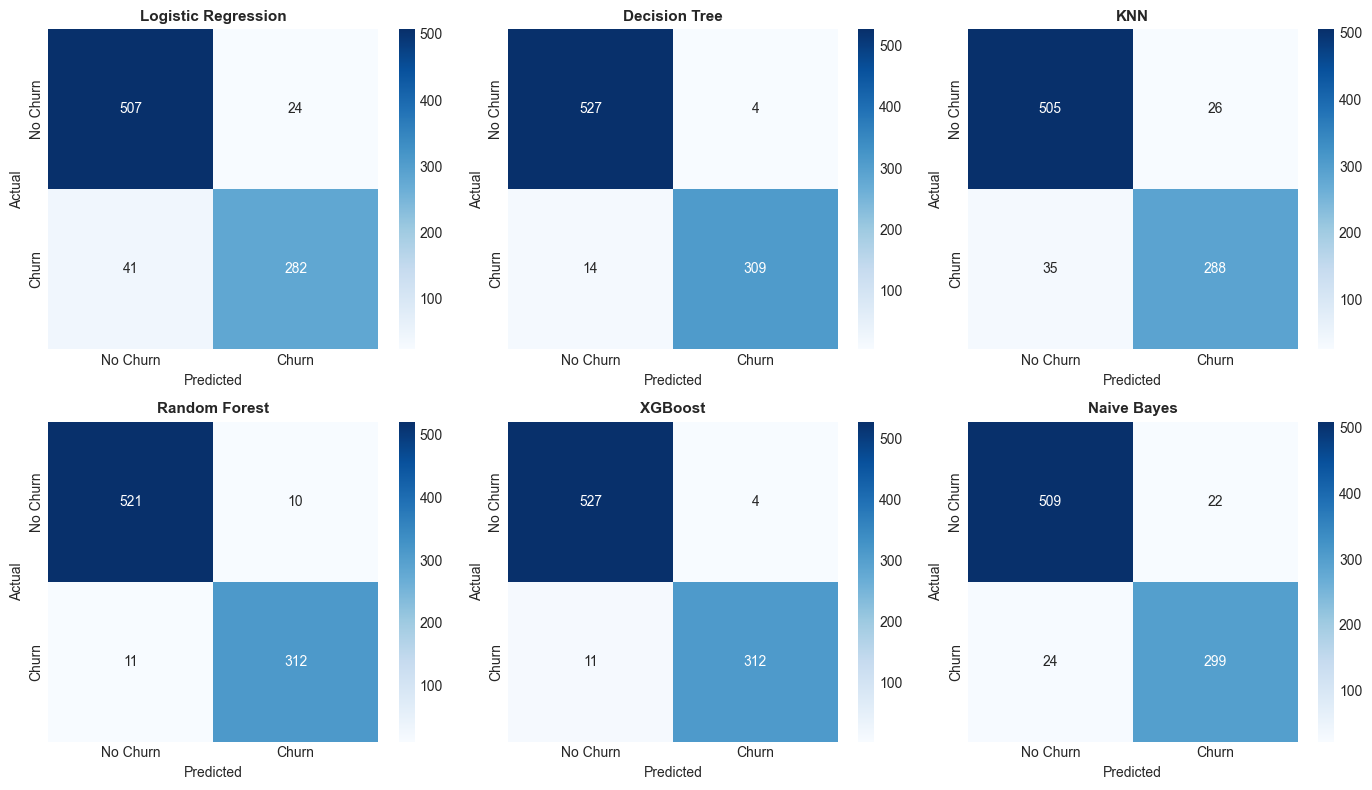

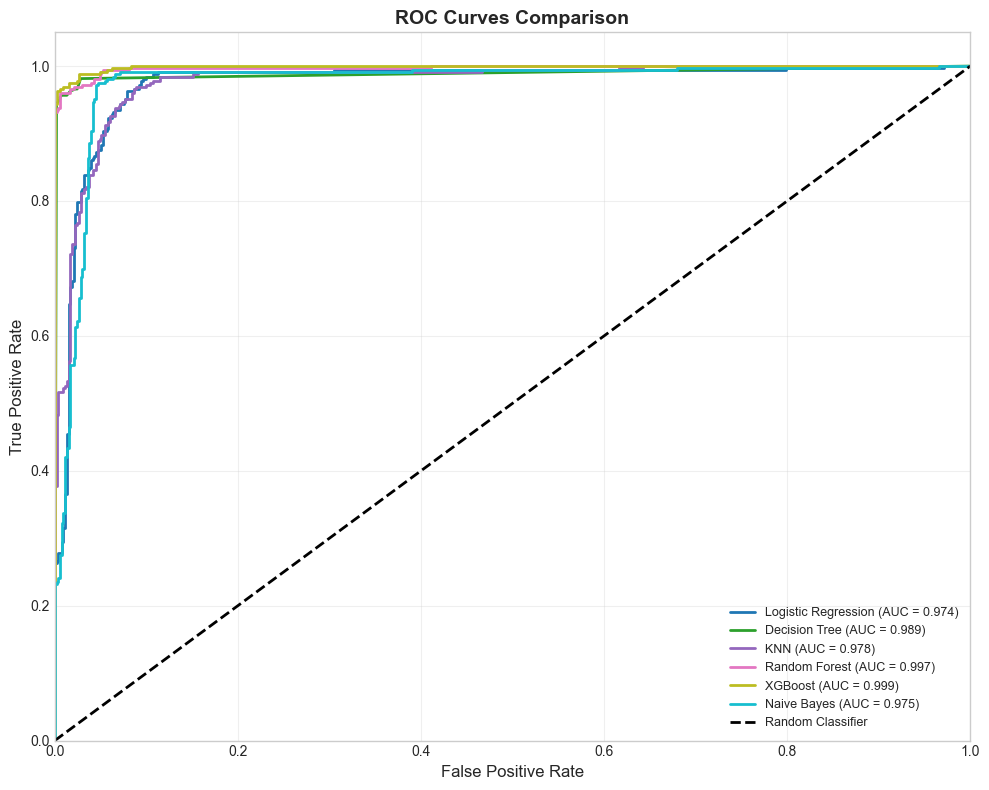

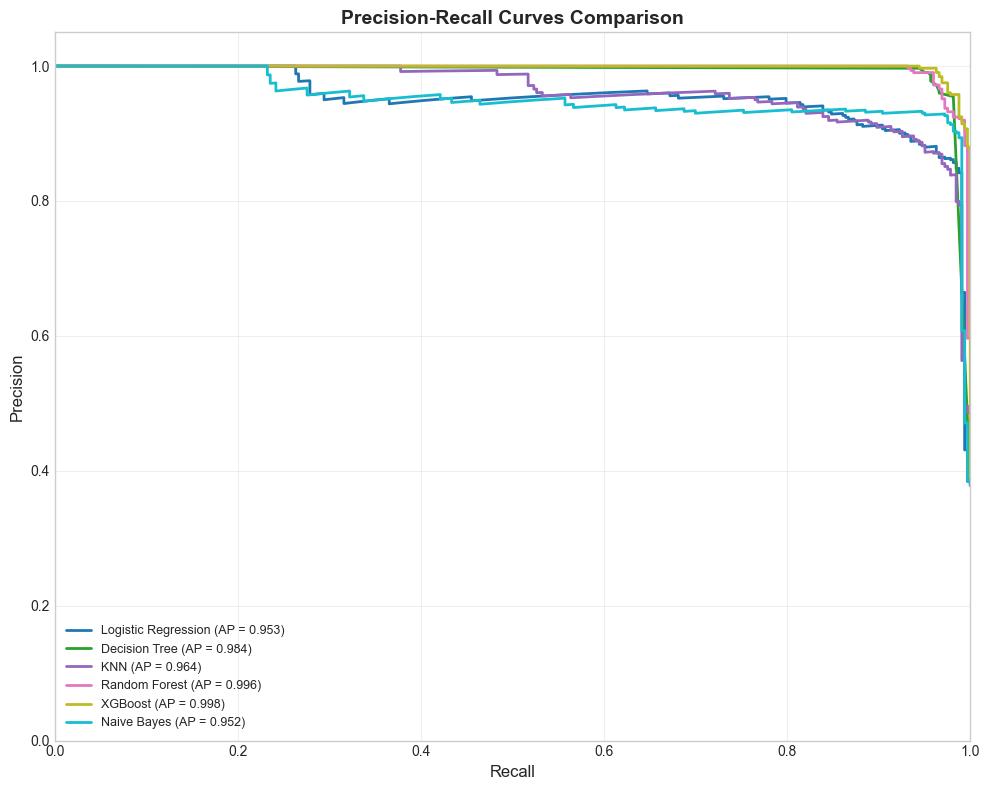

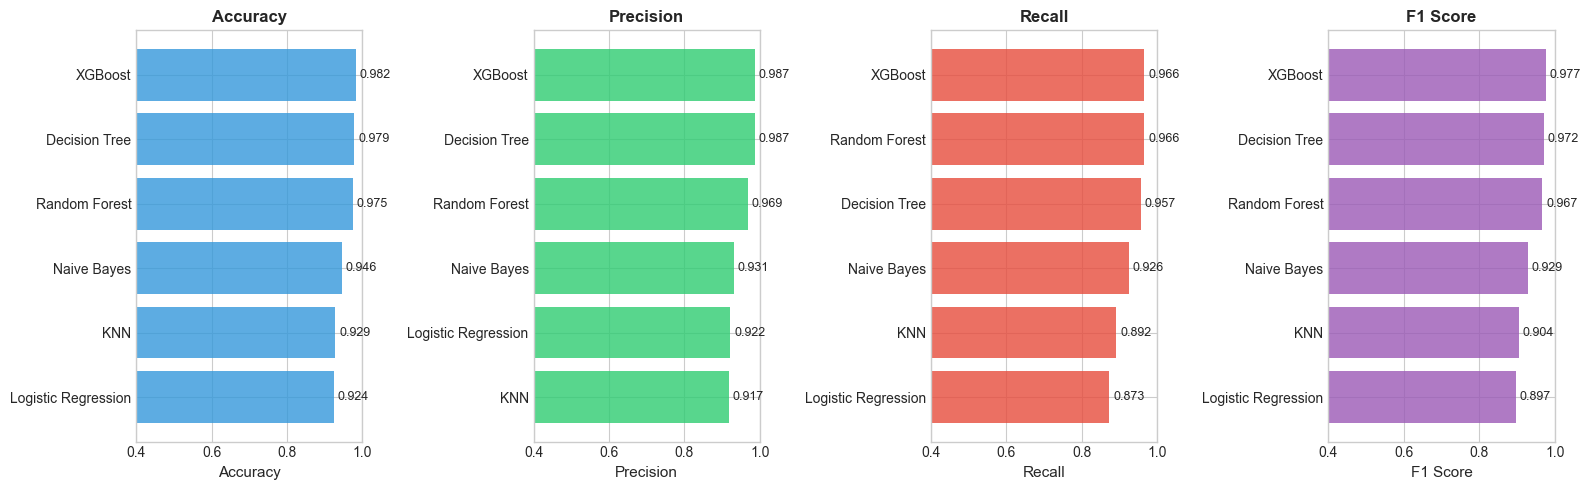

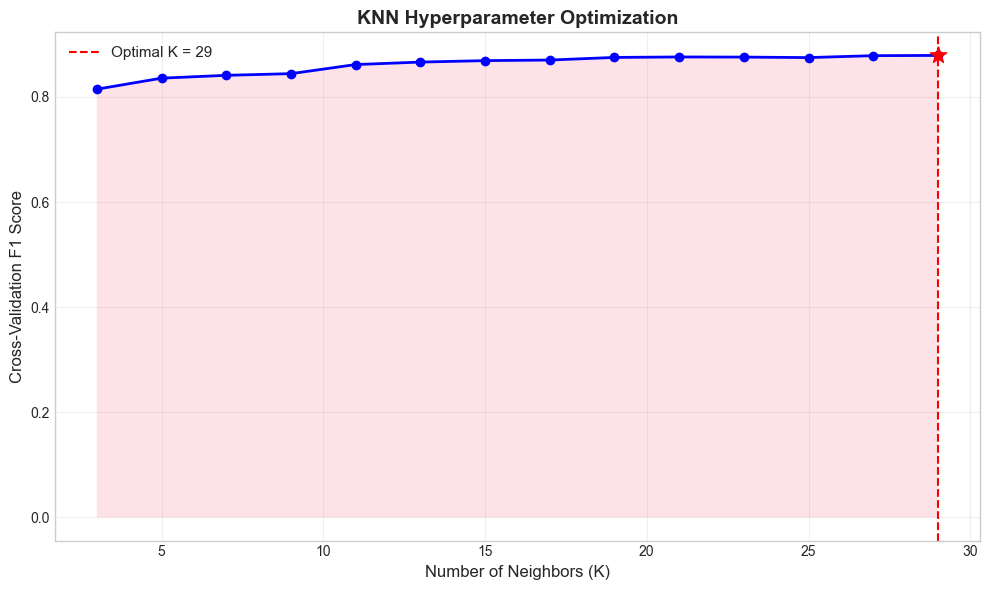


[4] FINAL SUMMARY

Model Performance Summary:
                     Accuracy  AUC Score  Precision  Recall  F1 Score  MCC Score
Model                                                                           
Logistic Regression    0.9239     0.9745     0.9216  0.8731    0.8967     0.8373
Decision Tree          0.9789     0.9889     0.9872  0.9567    0.9717     0.9552
KNN                    0.9286     0.9775     0.9172  0.8916    0.9042     0.8475
Random Forest          0.9754     0.9971     0.9689  0.9659    0.9674     0.9477
XGBoost                0.9824     0.9987     0.9873  0.9659    0.9765     0.9626
Naive Bayes            0.9461     0.9751     0.9315  0.9257    0.9286     0.8854

🏆 Best Performing Model (by F1 Score): XGBoost
   F1 Score: 0.9765
   Accuracy: 0.9824

Summary saved to: model_comparison_summary.csv


In [42]:


from xml.parsers.expat import model
import joblib


def main(data_path=None):

    print("="*70)
    print("Loan Approval Prediction - Model Comparison")
    print("="*70)

    # 1. Load data
    print("\n[1] LOADING DATA...")
    df = load_loan_data(data_path)

    if df is None:
        print("\nERROR: Could not load dataset. Please provide a valid path.")
        return None

    # 2. Explore data
    df = explore_data(df)
    # 3. Preprocess data
    X, y, preprocessor = preprocess_loan_data(df)
    X_train, X_test, y_train_encoded, y_test_encoded, le = prepare_data_splits(X, y)

    feature_names = X_train.columns
    
    # Store all predictions and probabilities
    all_predictions = {}
    all_probabilities = {}
    all_metrics = {}

    # 4. Train models
    print("\n[2] TRAINING MODELS...")

    # Logistic Regression
    pipeline = train_logistic_regression(X_train, y_train_encoded,preprocessor,le)
    lr_pred, lr_prob = test_logistic_regression(pipeline, X_test,y_test_encoded)
    all_predictions['Logistic Regression'] = lr_pred
    all_probabilities['Logistic Regression'] = lr_prob
    all_metrics['Logistic Regression'] = {
        'Accuracy': accuracy_score(y_test_encoded, lr_pred),
        'AUC Score': roc_auc_score(y_test_encoded, lr_prob),
        'Precision': precision_score(y_test_encoded, lr_pred),
        'Recall': recall_score(y_test_encoded, lr_pred),
        'F1 Score': f1_score(y_test_encoded, lr_pred),
        'MCC Score': matthews_corrcoef(y_test_encoded, lr_pred)
    }

    # Decision Tree
    dt_model = train_decision_tree(X_train, y_train_encoded,preprocessor,le)
    dt_pred, dt_prob = test_decision_tree(dt_model, X_test,y_test_encoded)
    all_predictions['Decision Tree'] = dt_pred
    all_probabilities['Decision Tree'] = dt_prob
    all_metrics['Decision Tree'] = {
        'Accuracy': accuracy_score(y_test_encoded, dt_pred),
        'AUC Score': roc_auc_score(y_test_encoded, dt_prob),
        'Precision': precision_score(y_test_encoded, dt_pred),
        'Recall': recall_score(y_test_encoded, dt_pred),
        'F1 Score': f1_score(y_test_encoded, dt_pred),
        'MCC Score': matthews_corrcoef(y_test_encoded, dt_pred)
    }

    # KNN
    pipeline, k_range, cv_scores = train_knn(X_train, y_train_encoded,preprocessor,le)
    knn_pred, knn_prob = test_knn(pipeline, X_test, y_test_encoded)
    all_predictions['KNN'] = knn_pred
    all_probabilities['KNN'] = knn_prob
    all_metrics['KNN'] = {
        'Accuracy': accuracy_score(y_test_encoded, knn_pred),
        'AUC Score': roc_auc_score(y_test_encoded, knn_prob),
        'Precision': precision_score(y_test_encoded, knn_pred),
        'Recall': recall_score(y_test_encoded, knn_pred),
        'F1 Score': f1_score(y_test_encoded, knn_pred),
        'MCC Score': matthews_corrcoef(y_test_encoded, knn_pred)
    }
    # SVM
    """svm_model = train_svm(X_train, y_train_encoded,preprocessor,le)
    svm_pred, svm_prob = test_svm(svm_model, X_test, y_test_encoded)
    all_predictions['SVM'] = svm_pred
    all_probabilities['SVM'] = svm_prob
    all_metrics['SVM'] = {
        'Accuracy': accuracy_score(y_test_encoded, svm_pred),
        'Precision': precision_score(y_test_encoded, svm_pred),
        'Recall': recall_score(y_test_encoded, svm_pred),
        'F1 Score': f1_score(y_test_encoded, svm_pred)
    }"""

    #Random Forest
    pipeline = train_Random_Forest(X_train, y_train_encoded,preprocessor,le)
    rf_pred, rf_prob = test_Random_Forest(pipeline, X_test, y_test_encoded)
    all_predictions['Random Forest'] = rf_pred
    all_probabilities['Random Forest'] = rf_prob
    all_metrics['Random Forest'] = {
        'Accuracy': accuracy_score(y_test_encoded, rf_pred),
        'AUC Score': roc_auc_score(y_test_encoded, rf_prob),
        'Precision': precision_score(y_test_encoded, rf_pred),
        'Recall': recall_score(y_test_encoded, rf_pred),
        'F1 Score': f1_score(y_test_encoded, rf_pred),
        'MCC Score': matthews_corrcoef(y_test_encoded, rf_pred)
    }

    #XGBoost
    pipeline = train_XGBoost(X_train, y_train_encoded,preprocessor,le)
    xgb_pred, xgb_prob = test_XGBoost(pipeline, X_test, y_test_encoded)
    all_predictions['XGBoost'] = xgb_pred
    all_probabilities['XGBoost'] = xgb_prob
    all_metrics['XGBoost'] = {
        'Accuracy': accuracy_score(y_test_encoded, xgb_pred),
        'AUC Score': roc_auc_score(y_test_encoded, xgb_prob),
        'Precision': precision_score(y_test_encoded, xgb_pred),
        'Recall': recall_score(y_test_encoded, xgb_pred),
        'F1 Score': f1_score(y_test_encoded, xgb_pred),
        'MCC Score': matthews_corrcoef(y_test_encoded, xgb_pred)    
    }
    # Ensemble Methods
    """ensemble_results = train_ensemble_models(X_train, y_train, X_test, y_test)

    for name, results in ensemble_results.items():
        all_predictions[name] = results['y_pred']
        all_probabilities[name] = results['y_prob']
        all_metrics[name] = {
            'Accuracy': accuracy_score(y_test, results['y_pred']),
            'Precision': precision_score(y_test, results['y_pred']),
            'Recall': recall_score(y_test, results['y_pred']),
            'F1 Score': f1_score(y_test, results['y_pred'])
        }"""
    # Naive Bayes
    pipeline = train_Naive_Bayes_models(X_train, y_train_encoded,preprocessor,le)
    y_pred_gnb, y_prob_gnb = test_Naive_Bayes_models(pipeline, X_test, y_test_encoded)
    all_predictions['Naive Bayes'] = y_pred_gnb
    all_probabilities['Naive Bayes'] = y_prob_gnb
    all_metrics['Naive Bayes'] = {
        'Accuracy': accuracy_score(y_test_encoded, y_pred_gnb),
        'AUC Score': roc_auc_score(y_test_encoded, y_prob_gnb),
        'Precision': precision_score(y_test_encoded, y_pred_gnb),
        'Recall': recall_score(y_test_encoded, y_pred_gnb),
        'F1 Score': f1_score(y_test_encoded, y_pred_gnb),
        'MCC Score': matthews_corrcoef(y_test_encoded, y_pred_gnb)
    }

    # 5. Generate visualizations
    print("\n[3] GENERATING VISUALIZATIONS...")

    plot_confusion_matrices(y_test_encoded, all_predictions)
    plot_roc_curves(y_test_encoded, all_probabilities)
    plot_precision_recall_curves(y_test_encoded, all_probabilities)
    plot_model_comparison(all_metrics)
    plot_knn_optimization(k_range, cv_scores)
    """plot_feature_importance(ensemble_results['Random Forest']['model'], feature_names,
                           'Random Forest', 'rf_feature_importance.png')
    plot_feature_importance(ensemble_results['Gradient Boosting']['model'], feature_names,
                           'Gradient Boosting', 'gb_feature_importance.png')"""

    # 6. Create summary
    print("\n[4] FINAL SUMMARY")
    print("="*70)

    summary_df = create_summary_table(all_metrics)
    print("\nModel Performance Summary:")
    print(summary_df.to_string())

    # Best model
    best_model = summary_df['F1 Score'].idxmax()
    print(f"\n🏆 Best Performing Model (by F1 Score): {best_model}")
    print(f"   F1 Score: {summary_df.loc[best_model, 'F1 Score']:.4f}")
    print(f"   Accuracy: {summary_df.loc[best_model, 'Accuracy']:.4f}")

    # Save summary to CSV
    summary_df.to_csv('model_comparison_summary.csv')
    print("\nSummary saved to: model_comparison_summary.csv")
    
    #move all models into a dictionary for saving
    """model = {
        'Logistic Regression': lr_model,
        'Decision Tree': dt_model,
        'KNN': knn_model,
        'Naive Bayes': gnb,
        'Random Forest': rf_model,
        'XGBoost': xgb_model,
        'Ensemble Models': ensemble_results,
        'SVM'  : svm_model
    }"""
    

    # Save model to file
    #joblib.dump(model, "loan_approval_model.pkl")

    return {
        'models': model,
        'predictions': all_predictions,
        'probabilities': all_probabilities,
        'metrics': all_metrics,
        'summary': summary_df
    }

if __name__ == "__main__":
  
    results = main()